# Deep Q-Learning for Portfolio Management

In [67]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gymnasium as gym
import seaborn as sns
from finta import TA
import tqdm
import seaborn as sns
import os

# Custom modules
import Python.agents as agents, Python.environment as environment

# Paths definition
image_path = os.getcwd() + "\\Images"
model_saving_path = os.getcwd() + "\\Models\\First Model"

# Part 1. Problem Definition

### 1.1 Introduction
Portfolio management is a critical area in finance where the goal is to allocate assets to maximize returns while minimizing risk. Traditional portfolio management techniques rely on historical data and statistical models to make investment decisions. However, these approaches can be limited in their ability to adapt to changing market conditions and learn from new data.
Reinforcement Learning (RL) presents a dynamic alternative to traditional methods. Unlike its counterparts, RL algorithms learn by interacting with the environment, making decisions, and receiving feedback in the form of rewards. This dynamic learning process equips RL-based models to adapt and optimize their strategies in real time, potentially leading to superior performance in the volatile and complex world of financial markets.

### 1.2 Project Structure
Thi project is divided in two sections:
1. __Data Analysis and Benchmark Creation:__ in this part of the project we analyse the selected asset and create the benchmark to compare a passive management approach with the _RL-based_ approach.

2. __Agent Training:__ in this part we select the features to use as input values for the model and compare the results between the benchmarks of the previous part.

But let's not waste any more time in chatter and dive into the project

## Part 2. Data Analysis and Benchmark Creation

### 2.1 Asset Selection
For the structure of our portfolio we selected 3 assets with a negetive or a low correlation between them, specifically:
- __Dow Jones Industrial Average (^DJI):__ is a stock market index that represents the performance of 30 large, publicly-owned companies based in the United States. It is one of the oldest and most widely followed equity indices, often used as a barometer of the overall health of the U.S. stock market and economy.

- __SPDR Gold Trust (GLD):__ is an exchange-traded fund (ETF) that tracks the price of gold. It offers investors a convenient and liquid way to gain exposure to the precious metal, often used as a hedge against inflation and market volatility.

- __iShares 20+ Year Treasury Bond ETF (TLT):__ is an ETF that seeks to track the investment results of an index composed of U.S. Treasury bonds with remaining maturities greater than 20 years. It is often used by investors as a way to gain exposure to long-term government bonds, typically viewed as a safer, lower-risk investment compared to equities.

To gather the daily data we use _Yahoo Finance_ database and selected OHLC data from __1st January 2020__ to __30th June 2024__. 

In [68]:
tickers = ['^DJI', 'GLD', 'TLT']

start_date = '2020-01-01'
end_date = '2024-06-30'

data = yf.download(tickers, start = start_date, end = end_date, group_by= 'ticker')

data

[*********************100%%**********************]  3 of 3 completed


Ticker              ^DJI                                            \
Price               Open          High           Low         Close   
Date                                                                 
2020-01-02  28638.970703  28872.800781  28627.769531  28868.800781   
2020-01-03  28553.330078  28716.310547  28500.359375  28634.880859   
2020-01-06  28465.500000  28708.019531  28418.630859  28703.380859   
2020-01-07  28639.179688  28685.500000  28565.279297  28583.679688   
2020-01-08  28556.140625  28866.179688  28522.509766  28745.089844   
...                  ...           ...           ...           ...   
2024-06-24  39184.488281  39571.230469  39184.488281  39411.210938   
2024-06-25  39398.789062  39423.261719  38997.230469  39112.160156   
2024-06-26  39063.148438  39183.738281  38908.988281  39127.800781   
2024-06-27  39107.101562  39250.691406  39026.750000  39164.058594   
2024-06-28  39092.390625  39443.601562  38937.148438  39118.859375   

Ticker                                      TLT                          \
Price          Adj Close     Volume        Open        High         Low   
Date                                                                      
2020-01-02  28868.800781  251820000  136.789993  137.529999  136.669998   
2020-01-03  28634.880859  239590000  138.270004  139.160004  137.880005   
2020-01-06  28703.380859  252760000  139.690002  139.710007  138.149994   
2020-01-07  28583.679688  258900000  138.220001  138.470001  137.639999   
2020-01-08  28745.089844  291750000  137.929993  138.309998  136.320007   
...                  ...        ...         ...         ...         ...   
2024-06-24  39411.210938  373940000   94.050003   94.339996   93.739998   
2024-06-25  39112.160156  339010000   94.070000   94.550003   94.040001   
2024-06-26  39127.800781  333100000   93.279999   93.470001   93.110001   
2024-06-27  39164.058594  338010000   93.519997   93.709999   93.419998   
2024-06-28  39118.859375  679630000   93.730003   93.769997   91.779999   

Ticker                                               GLD              \
Price            Close   Adj Close    Volume        Open        High   
Date                                                                   
2020-01-02  137.009995  122.672279  11034100  143.860001  144.210007   
2020-01-03  139.119995  124.561447  12366000  145.750000  146.320007   
2020-01-06  138.330002  123.854187  11369800  148.440002  148.479996   
2020-01-07  137.649994  123.245300   8381200  147.570007  148.139999   
2020-01-08  136.740005  122.430542  10621700  148.490005  148.610001   
...                ...         ...       ...         ...         ...   
2024-06-24   94.339996   93.728439  56939100  215.550003  215.940002   
2024-06-25   94.500000   93.887398  23160000  214.960007  215.309998   
2024-06-26   93.150002   92.546158  38489100  212.389999  213.110001   
2024-06-27   93.519997   92.913750  23140800  214.710007  215.500000   
2024-06-28   91.779999   91.185036  55119600  215.639999  215.809998   

Ticker                                                    
Price              Low       Close   Adj Close    Volume  
Date                                                      
2020-01-02  143.399994  143.949997  143.949997   7733800  
2020-01-03  145.399994  145.860001  145.860001  12272800  
2020-01-06  146.949997  147.389999  147.389999  14403300  
2020-01-07  147.429993  147.970001  147.970001   7978500  
2020-01-08  146.139999  146.860001  146.860001  22248500  
...                ...         ...         ...       ...  
2024-06-24  215.199997  215.630005  215.630005   4626900  
2024-06-25  214.119995  214.559998  214.559998   3847700  
2024-06-26  212.119995  212.580002  212.580002   4690300  
2024-06-27  214.449997  214.990005  214.990005   4977800  
2024-06-28  214.820007  215.009995  215.009995   3955100  

[1130 rows x 18 columns]

### 2.2 Data Analysis
Let's check the correlation between the assets and calculate the return of these assets during the selected period of time.

In [69]:
adjc = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close'].droplevel(1, axis = 1)

logret = np.log(adjc) - np.log(adjc.shift(1))
corr = logret.corr()

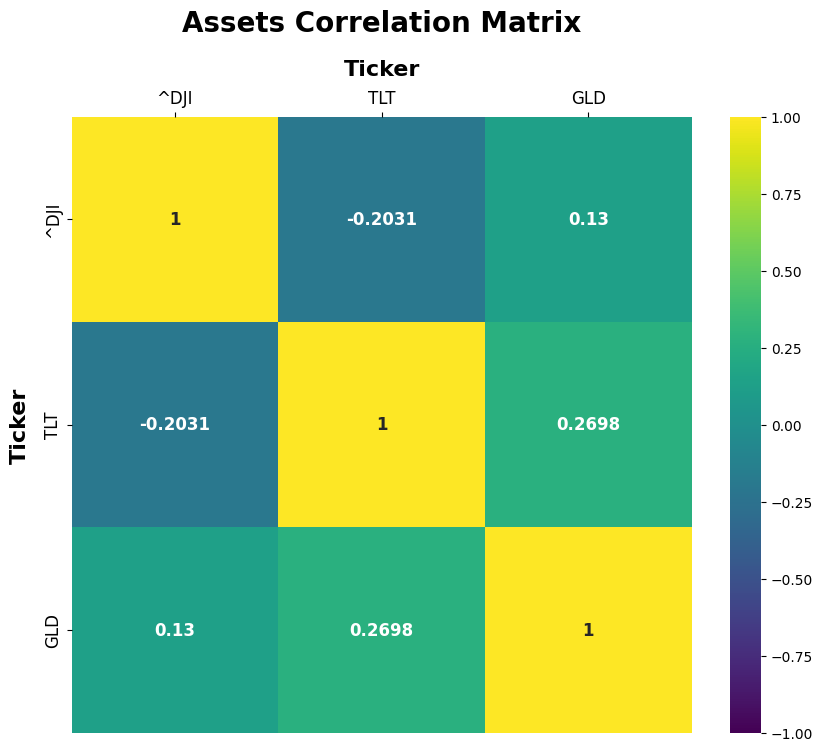

In [70]:
fig, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(corr, vmin = -1, vmax = 1, cmap="viridis", ax = ax,
             annot=True, fmt='.4g', annot_kws = {'fontweight' : 'bold', 'fontsize' : 12})

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

ax.set_xticks(ax.get_xticks(), corr.columns.values, fontsize = 12)
ax.set_yticks(ax.get_yticks(), corr.index.values, fontsize = 12)

ax.set_xlabel("Ticker", fontweight = 'bold', fontsize = 16, labelpad = 10)
ax.set_ylabel("Ticker", fontweight = 'bold', fontsize = 16, labelpad = 10)

ax.set_title("Assets Correlation Matrix", fontweight = 'bold', fontsize = 20, pad = 20)

plt.savefig(image_path + "\\Assets Correlation Matrix.png", dpi = 600)
plt.show()

C:\Users\axeli\AppData\Local\Temp\ipykernel_604\697836950.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  side_axs[i].set_xticklabels(side_axs[i].get_xticklabels(), rotation = 90)
C:\Users\axeli\AppData\Local\Temp\ipykernel_604\697836950.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axp.set_xticklabels(axp.get_xticklabels(), rotation = 90)


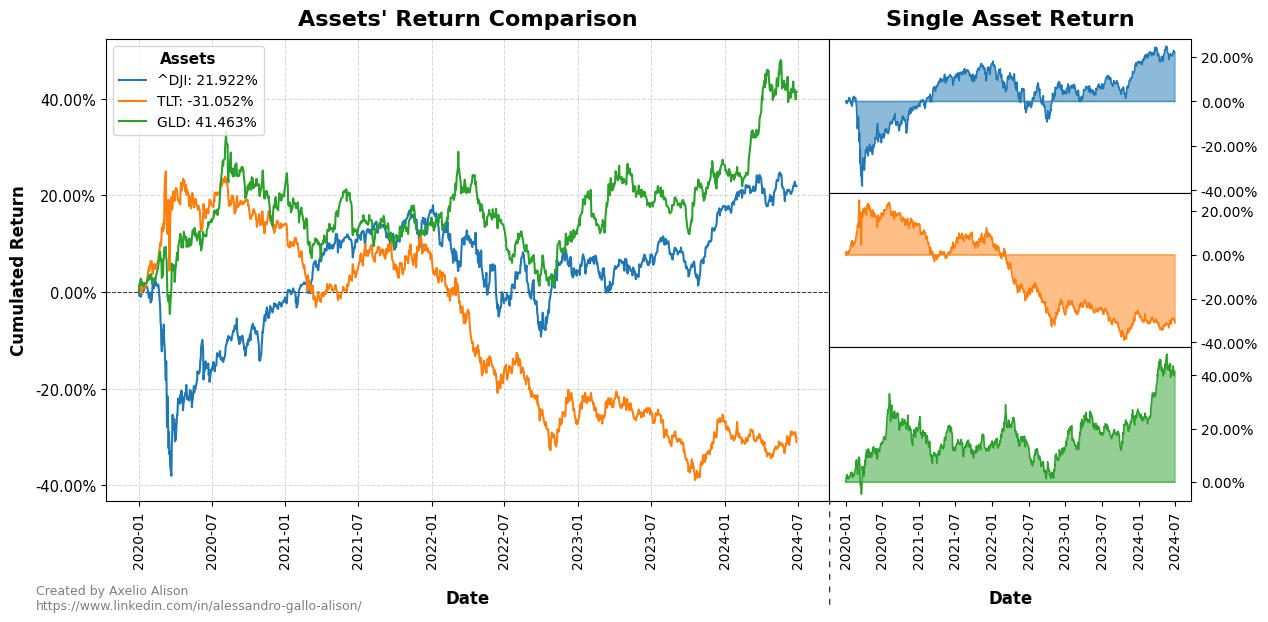

In [71]:
cum_ret = np.cumprod(logret + 1)
cum_ret.iloc[0] = 1
base_line = np.full(shape = len(cum_ret), fill_value = 1, dtype = np.int32)

fig = plt.figure(figsize = (14, 6), constrained_layout=False)

# Create a Grid Layout for a more complex visulization
gs1 = fig.add_gridspec(nrows=3, ncols=3, hspace = 0, wspace = 0)

axp = fig.add_subplot(gs1[0:3, 0:2])                                # Comparison Ax
side_axs = [fig.add_subplot(gs1[i:i+1, 2:]) for i in range(3)]      # Side Axes

# Draw grid
axp.set_axisbelow(True)
axp.grid(linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

# Draw base line
axp.axhline(y = 1, color = 'black', lw = 0.75, ls = '--', alpha = 0.75)

col = ['C0', 'C1', 'C2']

for i in range(3):
    serie = cum_ret.iloc[:, i]

    # Plot serie in the principal ax
    axp.plot(serie.index, serie.values, label = f"{serie.name}: {(serie.values[-1] - 1)*100:.3f}%", lw = 1.5, color = col[i])



    # Plot serie in the side ax
    side_axs[i].plot(serie.index, serie.values, label = serie.name, lw = 1, color = col[i])
    side_axs[i].plot(serie.index, base_line, lw = 1, color = col[i], alpha = 0.5)
    side_axs[i].fill_between(serie.index, serie.values, 1, color = col[i], alpha = 0.5)

    # Modify side ax parameter
    side_axs[i].yaxis.tick_right()
    side_axs[i].set_yticks(side_axs[i].get_yticks()[1:-1], [f'{(v - 1)*100:.2f}%' for v in side_axs[i].get_yticks()[1:-1]])

    if i != 2:
        side_axs[i].set_xticks([], [])
    else:
        side_axs[i].set_xticklabels(side_axs[i].get_xticklabels(), rotation = 90)
        side_axs[i].set_xlabel("Date", fontweight = 'bold', fontsize = 12, labelpad = 15)


# Modifiy principal ax parameters
axp.set_yticks(axp.get_yticks()[1:-1], [f'{(v - 1)*100:.2f}%' for v in axp.get_yticks()[1:-1]], fontsize = 10.5)
axp.set_xticklabels(axp.get_xticklabels(), rotation = 90)

# Set title and labels
axp.set_title("Assets' Return Comparison", fontweight = 'bold', fontsize = 16, pad = 10)
axp.set_ylabel("Cumulated Return", fontweight = 'bold', fontsize = 12, labelpad = 5)
axp.set_xlabel("Date", fontweight = 'bold', fontsize = 12, labelpad = 15)
side_axs[0].set_title("Single Asset Return", fontweight = 'bold', fontsize = 16, pad = 10)

# Add legend and modify its properties
axp.legend(loc = 2, title = "Assets", title_fontproperties = {'weight' : 'bold', 'size' : 11})

# Draw a line to separate subplots dates
axp.annotate('', xy=(1.0005, 0.1), xycoords='axes fraction', xytext=(1.0005, -0.23), arrowprops=dict(arrowstyle="-", color='black', lw = 0.75, linestyle = (0, (5, 7))))



fig.text(0.075, -0.05, "Created by Axelio Alison", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom',alpha = 0.5)
fig.text(0.075, -0.075, r"https://www.linkedin.com/in/alessandro-gallo-alison/", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom',alpha = 0.5)

plt.savefig(image_path + "\\Assets Returns Charts.png", dpi = 600, bbox_inches = 'tight')
plt.show()
   

### 2.3 Benchmark Construction
Now let's procede with constructing the benchmark we will use to evaluate the agent's performance. In order to make everything more realistic, we will divide data into a training set (_from 1st January 2020 to 31st December 2023_) and a test set (_from 1st January 2024 to 30th June 2024_)

Let's start by generating every possible portfolio using a Montecarlo for __Buy & Hold__ strategy and visualizing the results.

In [72]:
train_set1 = logret.loc[logret.index < '2023-12-31']
test_set1 = logret.loc[logret.index >= '2023-12-31']

In order to calculate the _Sharpe Ratio_ in the proper way, we will annualize the daily sharpe ratio using the following formula:
$$
\text{Sharpe Ratio}_{annualy} = \sqrt{252}*\text{Sharpe Ratio}_{daily}
$$

Since there are 252 trading days in a year.

In [73]:
# Simulating efficient frontier with training set
portfolios = []
weights = {'GLD w' : [], '^DJI w' : [], 'TLT w' : []}
portfolios_data = {'mean' : [], 'std' : [], 'sharpe_ratio' : []}

for _ in range(5000):

    # Generate Random Weights
    w = np.random.uniform(size = 3)
    w = w/w.sum()
    for i, k in enumerate(weights.keys()): weights[k].append(w[i])

    # Append the simulation to a list
    p_ret = (train_set1*(w)).sum(axis = 1)
    portfolios.append(np.cumprod(p_ret + 1))

    portfolios_data['mean'].append(np.mean(p_ret))
    portfolios_data['std'].append(np.std(p_ret))
    portfolios_data['sharpe_ratio'].append((np.mean(p_ret)/np.std(p_ret))*np.sqrt(252))

portfolios_data_df = pd.DataFrame(weights | portfolios_data)


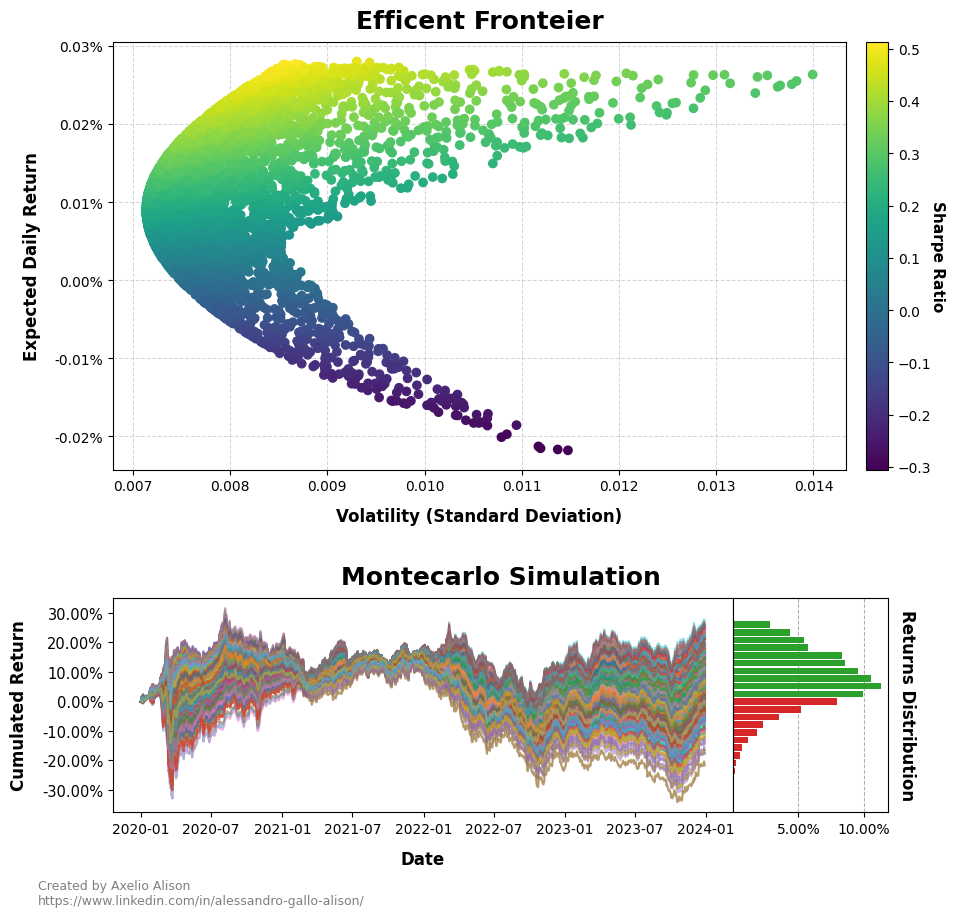

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Generate figure structure
fig = plt.figure(figsize = (10, 10), constrained_layout=False)
gs = fig.add_gridspec(nrows=2, ncols=2, hspace = 0.4, wspace = 0, height_ratios = [2, 1], width_ratios = [4, 1])

axs = []

axs.append(fig.add_subplot(gs[0, :]))                       # Efficent frontier Ax

ax_bottom = fig.add_subplot(gs[1, :])                       # This subplot is used to create a common bottom title
axs.append(fig.add_subplot(gs[1, 0]))                       # Montecarlo Simulation Ax
axs.append(fig.add_subplot(gs[1, 1], sharey = axs[1]))      # Montecarlo Simulation Results Distribution Ax


# Draw grid
axs[0].set_axisbelow(True)
axs[0].grid(linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

# Plot Efficient frontier chart
sc = axs[0].scatter(portfolios_data_df['std'], portfolios_data_df['mean'], c = portfolios_data_df['sharpe_ratio'])

# Add colorbar based on shrape ratio
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='3%', pad=0.2)
fig.colorbar(sc, cax=cax, orientation='vertical')

# Midify ticks
axs[0].set_yticks(axs[0].get_yticks()[1:-1], [f'{v*100:.2f}%' for v in axs[0].get_yticks()[1:-1]])

# Add title and axis label
axs[0].set_title("Efficent Fronteier", fontsize = 18, fontweight = 'bold', pad = 10)
axs[0].set_xlabel("Volatility (Standard Deviation)", labelpad = 10, fontsize = 12, fontweight = 'bold')
axs[0].set_ylabel("Expected Daily Return", labelpad = 10, fontsize = 12, fontweight = 'bold')
cax.set_ylabel("Sharpe Ratio", rotation = -90, labelpad = 10, fontsize = 11, fontweight = 'bold')



# Plot Montecarlo Simulation Portfolios
for p in [portfolios[i] for i in np.random.choice(len(portfolios), 500)]:
    axs[1].plot(p.index, p.values, alpha = 0.5)

# Modify ticks
axs[1].set_yticks(1 + np.linspace(-0.4, 0.4, 9)[1:-1], [f'{v*100:.2f}%' for v in np.linspace(-0.4, 0.4, 9)[1:-1]], fontsize = 10.5)

# Add Y Label
axs[1].set_xlabel("Date", labelpad = 10, fontsize = 12, fontweight = 'bold')
axs[1].set_ylabel("Cumulated Return", labelpad = 10, fontsize = 12, fontweight = 'bold')


# Plot Montecarlo Simulation Return Distribution
returns = [p.iloc[-1] for p in portfolios]

# Plot grid
axs[2].set_axisbelow(True)
axs[2].grid(axis = 'x', linestyle = 'dashed', linewidth = 0.75)

# Plot Returns Distribution histogram
n, bins, patches = axs[2].hist(returns, bins = 20, orientation = 'horizontal', rwidth = 0.85, weights = [1/len(returns)]*len(returns))
for i in np.where(bins < 1)[0]:
    patches[i].set_facecolor('C3')
for i in np.where(bins >= 1)[0][:-1]:
    patches[i].set_facecolor('C2')

# Modify ticks
axs[2].tick_params(left=False, labelleft = False)
axs[2].set_xticks(axs[2].get_xticks()[1:-1], [f'{v*100:.2f}%' for v in axs[2].get_xticks()[1:-1]])

# Add Y Label
axs[2].yaxis.set_label_position("right")
axs[2].set_ylabel("Returns Distribution", rotation = -90, labelpad = 20, fontsize = 12, fontweight = 'bold')

# Add common title for Montecarlo Simulation charts
ax_bottom.set_axis_off()
ax_bottom.set_title("Montecarlo Simulation", fontsize = 18, fontweight = 'bold', pad = 10)



fig.text(0.05, 0.03, "Created by Axelio Alison", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)
fig.text(0.05, 0.015, r"https://www.linkedin.com/in/alessandro-gallo-alison/", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)

# Save and plot figure
plt.savefig(image_path + "\\Montecarlo Simulation and Efficient Frontier.png", dpi = 600, bbox_inches = 'tight')
plt.show()

Now, let's select two portfolios as benchmarks:
- __The Minimum Volatility Portfolio__
- __The Maximum Sharpe Ratio Portfolio__

After finding these two portfolios, we extract the weights and conduct a simulation on the test set to acquire results for comparing the agent's performance.

In [75]:
max_sr_i = portfolios_data_df['sharpe_ratio'].idxmax()
max_sr_w = np.array(portfolios_data_df.iloc[max_sr_i, :3])
max_sr_r = (test_set1*max_sr_w).sum(axis = 1)
max_sr_p = np.cumprod(max_sr_r + 1)

min_std_i = portfolios_data_df['std'].idxmin()
min_std_w = np.array(portfolios_data_df.iloc[min_std_i, :3])
min_std_r = (test_set1*min_std_w).sum(axis = 1)
min_std_p = np.cumprod(min_std_r + 1)

In [76]:
def drawdown(ret_s):
    cum_ret = (ret_s + 1).cumprod()
    max_ret = cum_ret.cummax()
    drawdown = cum_ret/max_ret - 1

    return drawdown

drawdown(max_sr_r).min()

-0.04924514023317361

In [77]:
# Calulcate Portfolios Metrics

metrics_str = f"""----- Portfolio Metrics -----

** Max Sharpe Ratio Portfolio **
- Weights: [GLD: {max_sr_w[0]:.4f}, ^DJI: {max_sr_w[1]:.4f}, TLT: {max_sr_w[2]:.4f}]
- Average Daily Return: {np.average(max_sr_r)*100:.6f} %
- Risk: {np.std(max_sr_r):.6f}
- Shrape Ratio: {np.average(max_sr_r)/np.std(max_sr_r)*np.sqrt(252):.4f}
- Max DD (Drawdown): {drawdown(max_sr_r).min()*100:.4f} %

** Min Risk Portfolio **
- Weights: [GLD: {min_std_w[0]:.4f}, ^DJI: {min_std_w[1]:.4f}, TLT: {min_std_w[2]:.4f}]
- Average Daily Return: {np.average(min_std_r)*100:.6f} %
- Risk: {np.std(min_std_r):.6f}
- Shrape Ratio: {np.average(min_std_r)/np.std(min_std_r)*np.sqrt(252):.4f}
- Max DD (Drawdown): {drawdown(min_std_r).min()*100:.4f} %
"""

print(metrics_str)

----- Portfolio Metrics -----

** Max Sharpe Ratio Portfolio **
- Weights: [GLD: 0.2849, ^DJI: 0.0017, TLT: 0.7134]
- Average Daily Return: 0.076080 %
- Risk: 0.007229
- Shrape Ratio: 1.6707
- Max DD (Drawdown): -4.9245 %

** Min Risk Portfolio **
- Weights: [GLD: 0.2864, ^DJI: 0.3611, TLT: 0.3525]
- Average Daily Return: 0.025129 %
- Risk: 0.005835
- Shrape Ratio: 0.6837
- Max DD (Drawdown): -3.4866 %



C:\Users\axeli\AppData\Local\Temp\ipykernel_604\4076260943.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axp.set_xticklabels(axp.get_xticklabels(), rotation = 90)
C:\Users\axeli\AppData\Local\Temp\ipykernel_604\4076260943.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  side_axs[i].set_xticklabels(side_axs[i].get_xticklabels(), rotation = 90)


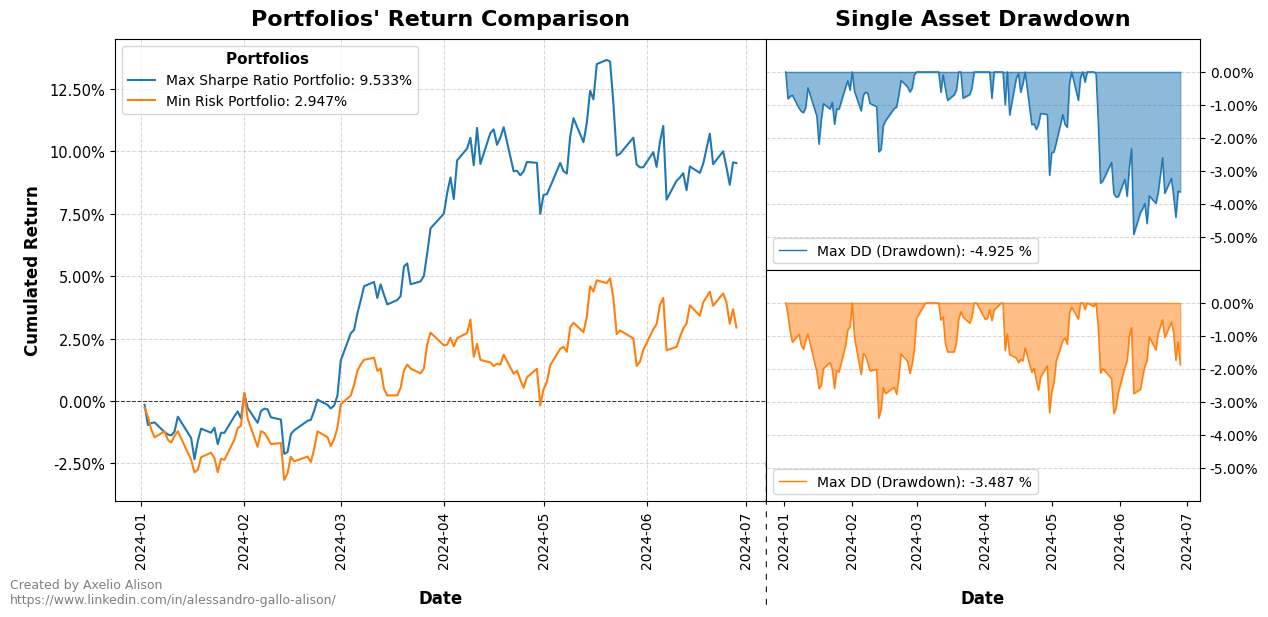

In [78]:
base_line = np.full(shape = len(max_sr_p), fill_value = 0, dtype = np.int32)



fig = plt.figure(figsize = (14, 6), constrained_layout=False)

# Create a Grid Layout for a more complex visulization
gs = fig.add_gridspec(nrows=2, ncols=2, hspace = 0, wspace = 0, width_ratios = [1.5, 1])

axp = fig.add_subplot(gs[:, 0])                                     # Comparison Ax
side_axs = [fig.add_subplot(gs[i, 1]) for i in range(2)]            # Side Axes



# Draw grid
axp.set_axisbelow(True)
axp.grid(linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

# Draw base line
axp.axhline(y = 1, color = 'black', lw = 0.75, ls = '--', alpha = 0.75)

# Plot series in the principal ax
axp.plot(max_sr_p.index, max_sr_p.values, label = f"Max Sharpe Ratio Portfolio: {(max_sr_p.values[-1] - 1)*100:.3f}%", lw = 1.5, color = 'C0')
axp.plot(min_std_p.index, min_std_p.values, label = f"Min Risk Portfolio: {(min_std_p.values[-1] - 1)*100:.3f}%", lw = 1.5, color = 'C1')

# Modifiy principal ax parameters
axp.set_yticks(axp.get_yticks()[1:-1], [f'{(v - 1)*100:.2f}%' for v in axp.get_yticks()[1:-1]], fontsize = 10.5)
axp.set_xticklabels(axp.get_xticklabels(), rotation = 90)

# Set title and labels
axp.set_title("Portfolios' Return Comparison", fontweight = 'bold', fontsize = 16, pad = 10)
axp.set_ylabel("Cumulated Return", fontweight = 'bold', fontsize = 12, labelpad = 5)
axp.set_xlabel("Date", fontweight = 'bold', fontsize = 12, labelpad = 15)
side_axs[0].set_title("Single Asset Drawdown", fontweight = 'bold', fontsize = 16, pad = 10)


# Plot drawdown series in seide axes
side_axs[0].plot(max_sr_p.index, drawdown(max_sr_r).values, lw = 1, color = 'C0', label = f"Max DD (Drawdown): {drawdown(max_sr_r).min()*100:.3f} %")
side_axs[0].plot(max_sr_p.index, base_line, lw = 1, color = 'C0', alpha = 0.5)
side_axs[0].fill_between(max_sr_p.index,  drawdown(max_sr_r).values, 0, color = 'C0', alpha = 0.5)

side_axs[1].plot(min_std_p.index, drawdown(min_std_r).values, lw = 1, color = 'C1', label = f"Max DD (Drawdown): {drawdown(min_std_r).min()*100:.3f} %")
side_axs[1].plot(min_std_p.index, base_line, lw = 1, color = 'C1', alpha = 0.5)
side_axs[1].fill_between(min_std_p.index, drawdown(min_std_r).values, 0, color = 'C1', alpha = 0.5)

# Modify side ax parameter
for i in range(2):

    side_axs[i].set_axisbelow(True)
    side_axs[i].grid(axis = 'y', linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

    side_axs[i].yaxis.tick_right()
    side_axs[i].set_yticks(np.linspace(-0.05, 0, 6), [f'{v:.2f}%' for v in np.linspace(-5, 0, 6)])
    side_axs[i].set_ylim((-0.06,0.01))
    
    side_axs[i].legend(loc = 3)

    if i != 1:
        side_axs[i].set_xticks([], [])
    else:
        side_axs[i].set_xticklabels(side_axs[i].get_xticklabels(), rotation = 90)
        side_axs[i].set_xlabel("Date", fontweight = 'bold', fontsize = 12, labelpad = 15)



# Add legend and modify its properties
axp.legend(loc = 2, title = "Portfolios ", title_fontproperties = {'weight' : 'bold', 'size' : 11})

# Draw a line to separate subplots dates
axp.annotate('', xy=(1.0005, 0.1), xycoords='axes fraction', xytext=(1.0005, -0.23), arrowprops=dict(arrowstyle="-", color='black', lw = 0.75, linestyle = (0, (5, 7))))



fig.text(0.05, -0.04, "Created by Axelio Alison", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)
fig.text(0.05, -0.065, r"https://www.linkedin.com/in/alessandro-gallo-alison/", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)

plt.savefig(image_path + "\\Portfolios Returns Charts.png", dpi = 600, bbox_inches = 'tight')
plt.show()

### 3. Agent Training
Once we have defined the benchmark metrics for comparison, the next step is to train the agent and preprocess the input data for use in the Deep Neural Network.
#### 3.1 Preprocessing
First, we calculate a series of financial indicators to be used in calculating percentage variations. Specifically, the calculated indicators are:

__1. Simple Moving Average (SMA)__

&emsp;__Explanation__: SMA is the average of a selected range of prices, usually closing prices, over a specified period.<br>
&emsp;__Formula__: 
$$
\text{SMA} = \frac{P_1 + P_2 + \dots + P_n}{n}
$$
&emsp;Where $( P )$ is the price at each time period, and $( n )$ is the number of periods.
<br><br>

__2. Exponential Moving Average (EMA)__

&emsp;__Explanation__: EMA gives more weight to recent prices, making it more responsive to new information.<br>
&emsp;__Formula__:
$$
\text{EMA} = \left[ P_t \times \left( \frac{2}{n+1} \right) \right] + \left[ \text{EMA}_{y} \times \left( 1 - \frac{2}{n+1} \right) \right]
$$
&emsp;Where $( P_t )$ is the price at time $( t )$, $( n )$ is the number of periods, and $( \text{EMA}_y )$ is the EMA of the previous period.
<br><br>

__3. Relative Strenght Index (RSI)__

&emsp;__Explanation__: RSI measures the speed and change of price movements to identify overbought or oversold conditions.<br>
&emsp;__Formula__:
$$
\text{RSI} = 100 - \left( \frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}} \right)
$$
&emsp;Where Average Gain and Average Loss are calculated over a specified period, typically 14 periods.
<br><br>

__4. Stochastic Oscillator (%K)__

&emsp;__Explanation__: $\text{\%K}$ measures the current price relative to the range over a specified period to identify momentum.<br>
&emsp;__Formula__:
$$
\text{\%K} = \frac{(C - L_{n})}{(H_{n} - L_{n})} \times 100
$$
&emsp;Where $( C )$ is the latest closing price, $( L_n )$ is the lowest price over the last $( n )$ periods, and $( H_n )$ is the highest price over the last $( n )$ periods.
<br><br>

__5. Stochastic Oscillator (%D)__

&emsp;__Explanation__: $\text{\%D}$ is the moving average of %K and is used to smooth out the %K line.<br>
&emsp;__Formula__:
$$
\text{\%D} = \text{SMA of \%K over a specified period, usually 3}
$$
<br><br>

__6. Commodity Channel Index (CCI)__

&emsp;__Explanation__: $\text{CCI}$ identifies cyclical trends in a security by comparing the current price to its moving average and deviations from that average.<br>
&emsp;__Formula__:
$$
\text{CCI} = \frac{(P_t - \text{SMA})}{0.015 \times \text{Mean Deviation}}
$$
&emsp;Where $( P_t )$ is the typical price $\left(\frac{H + L + C}{3}\right)$, $\text{SMA}$ is the Simple Moving Average of the typical price, and $\text{Mean Deviation}$ is the average of the absolute deviations from the SMA.


In [79]:
tickers_dict = {}
tickers_ind_dict = {}
tickers_fin_dict = {}

ind_names = ['SMA_30', 'EMA_30', 'RSI_14', 'STOCHK_14', 'STOCHD_3', 'CCI_20']

for t in tickers:

    # Isolate Tickers
    df = data.loc[:, data.columns.get_level_values(0) == t]
    df.columns = df.columns.droplevel(0)
    tickers_dict[t] = df

    # Calculate Indicators
    ind = []
    ind.append(TA.SMA(df, 30))
    ind.append(TA.EMA(df, 30))
    ind.append(TA.RSI(df)/100)
    ind.append(TA.STOCH(df)/100)
    ind.append(TA.STOCHD(df)/100)
    ind.append(TA.CCI(df)/100)

    # Create Indicators Dataframe
    ind_df = pd.concat(ind, axis = 1)
    ind_df.rename(columns = {k:v for (k, v) in zip(ind_df.columns, ind_names)}, inplace = True)

    tickers_ind_dict[t] = ind_df

    # Calculate other values
    df = df.drop(columns = ['Volume', 'Adj Close'])

    # Create relative variations dictionary
    info_dict = {}

    info_dict['C/H(0)'] = df['Close']/df['High'] - 1
    info_dict['C/L(0)'] = df['Close']/df['Low'] - 1
    info_dict['C/O(0)'] = df['Close']/df['Open'] - 1

    info_dict['C/C(-1)'] = df['Close']/df['Close'].shift(1) - 1
    info_dict['C/H(-1)'] = df['Close']/df['High'].shift(1) - 1
    info_dict['C/L(-1)'] = df['Close']/df['Low'].shift(1) - 1
    info_dict['C/O(-1)'] = df['Close']/df['Open'].shift(1) - 1

    info_dict['C/C(-2)'] = df['Close']/df['Close'].shift(2) - 1
    info_dict['C/H(-2)'] = df['Close']/df['High'].shift(2) - 1
    info_dict['C/L(-2)'] = df['Close']/df['Low'].shift(2) - 1
    info_dict['C/O(-2)'] = df['Close']/df['Open'].shift(2) - 1

    info_dict['C/C(-3)'] = df['Close']/df['Close'].shift(3) - 1
    info_dict['C/H(-3)'] = df['Close']/df['High'].shift(3) - 1
    info_dict['C/L(-3)'] = df['Close']/df['Low'].shift(3) - 1
    info_dict['C/O(-3)'] = df['Close']/df['Open'].shift(3) - 1

    info_dict['SMA_30/SMA_30(-1)'] = ind_df['SMA_30']/ind_df['SMA_30'].shift(1) - 1
    info_dict['SMA_30/SMA_30(-2)'] = ind_df['SMA_30']/ind_df['SMA_30'].shift(2) - 1
    info_dict['SMA_30/SMA_30(-3)'] = ind_df['SMA_30']/ind_df['SMA_30'].shift(3) - 1

    info_dict['EMA_30/EMA_30(-1)'] = ind_df['EMA_30']/ind_df['EMA_30'].shift(1) - 1
    info_dict['EMA_30/EMA_30(-2)'] = ind_df['EMA_30']/ind_df['EMA_30'].shift(2) - 1
    info_dict['EMA_30/EMA_30(-3)'] = ind_df['EMA_30']/ind_df['EMA_30'].shift(3) - 1

    # Create final dataframe
    tickers_fin_dict[t] = pd.concat([pd.DataFrame(info_dict), ind_df.iloc[:, 2:]], axis = 1)
    tickers_fin_dict[t].rename(columns = {k:f"{t}-{k}" for k in tickers_fin_dict[t].columns}, inplace = True)

In [80]:
# Create X and Y matrix to use for model training
X = pd.concat(tickers_fin_dict.values(), axis = 1)
Y = adjc.pct_change(1)

# Training and Testing division
train_cond = (X.index > '2020-02-29') & (X.index <= '2023-12-31')
test_cond = (X.index > '2023-12-31')

X_train = X.loc[train_cond]
Y_train = Y.loc[train_cond]
X_test = X.loc[test_cond]
Y_test = Y.loc[test_cond]

#### 3.2 Training
Once we have the data to use for model training, let's start with writing the code for agent training.

In [81]:
def agent_train(agent_, env_, state_size_, episodes_n = 20, model_path = "", save_agent = True):

    for ep in range(episodes_n):

        state = env_.reset()
        state = np.reshape(state, [1, state_size_])

        i = 0

        with tqdm.tqdm(range(len(X_train)+ 10), unit = 'train') as tq_time:
            for time in tq_time:
                tq_time.set_description(f"Episode: {0}, Time: {i}, Epsilon: {agent_.epsilon:.4}. Target Model Updated {i%10} steps ago")
                action = agent_.act(state)
                #print(action)
                next_state, reward, done, _ = env_.step(action, render = False)

                next_state = np.reshape(next_state, [1, state_size_])

                agent_.remember(state, action, reward, next_state, done)
                state = next_state

                if done:
                    print(f"\nEpisode: {ep+1}/{20}, Epsilon: {agent_.epsilon:.2}")
                    break
                    
                if len(agent_.memory) > 30:
                    agent_.replay(15)
                
                i += 1

                if i % 10 == 0:
                    agent_.update_target_model()
    
    if save_agent:
        agent_.save(model_path, ep)

In [82]:
# Defining trading environment for training set
env = environment.PortfolioEnv(len(tickers), X_train, Y_train)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initializing the D3QN Agent
agent = agents.D3QNAgent(state_size, action_size)

# Since the training requires to much time we will comment this part and load the final model
#agent_train(agent, env, state_size, model_path = model_saving_path)

# Loading the final model
ep = agent.load(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model")

c:\Users\axeli\Desktop\Github\first-child\.first-child-venv\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


This agent was trained for only 10 episodes since the computational power I had was not enough to run a more complex model for more episodes. However, once we have the agent with the loaded policy, we can simulate the agent's behaviour in the environment created using the test set. 

Then we will compare the performace of the portfolio managed by the agent with the performance of the two benchmarks using the following metrics:
- __Average Return__
- __Volatility (Standard Deviation)__
- __Sharpe Ratio__
- __Max Drawndown__

In [83]:
# Defining trading environment for test set
test_env = environment.PortfolioEnv(len(tickers), X_test, Y_test)

state = test_env.reset()
state = np.reshape(state, [1, state_size])

# Starting agent simulation
while True:
    action = agent.act(state, training = False)
    
    next_state, reward, done, _ = test_env.step(action, render = False)
    next_state = np.reshape(next_state, [1, state_size])

    state = next_state

    if done:
        break

In [84]:
agent_df = pd.DataFrame(test_env.capital_y, index = test_env.capital_x)

agent_r = agent_df.pct_change()[0]
agent_p = np.cumprod(agent_r + 1)

In [85]:
metrics_str_2 = f"""
** Agent Portfolio **
- Average Daily Return: {np.average(agent_r[1:])*100:.6f} %
- Risk: {np.std(agent_r[1:]):.6f}
- Shrape Ratio: {(np.average(agent_r[1:])/np.std(agent_r[1:]))*np.sqrt(252):.4f}
- Max DD (Drawdown): {drawdown(agent_r).min()*100:.4f} %
"""

print(metrics_str + metrics_str_2)

----- Portfolio Metrics -----

** Max Sharpe Ratio Portfolio **
- Weights: [GLD: 0.2849, ^DJI: 0.0017, TLT: 0.7134]
- Average Daily Return: 0.076080 %
- Risk: 0.007229
- Shrape Ratio: 1.6707
- Max DD (Drawdown): -4.9245 %

** Min Risk Portfolio **
- Weights: [GLD: 0.2864, ^DJI: 0.3611, TLT: 0.3525]
- Average Daily Return: 0.025129 %
- Risk: 0.005835
- Shrape Ratio: 0.6837
- Max DD (Drawdown): -3.4866 %

** Agent Portfolio **
- Average Daily Return: 0.040573 %
- Risk: 0.003705
- Shrape Ratio: 1.7384
- Max DD (Drawdown): -2.5153 %



C:\Users\axeli\AppData\Local\Temp\ipykernel_604\4066670506.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axp.set_xticklabels(axp.get_xticklabels(), rotation = 90)
C:\Users\axeli\AppData\Local\Temp\ipykernel_604\4066670506.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  side_axs[i].set_xticklabels(side_axs[i].get_xticklabels(), rotation = 90)


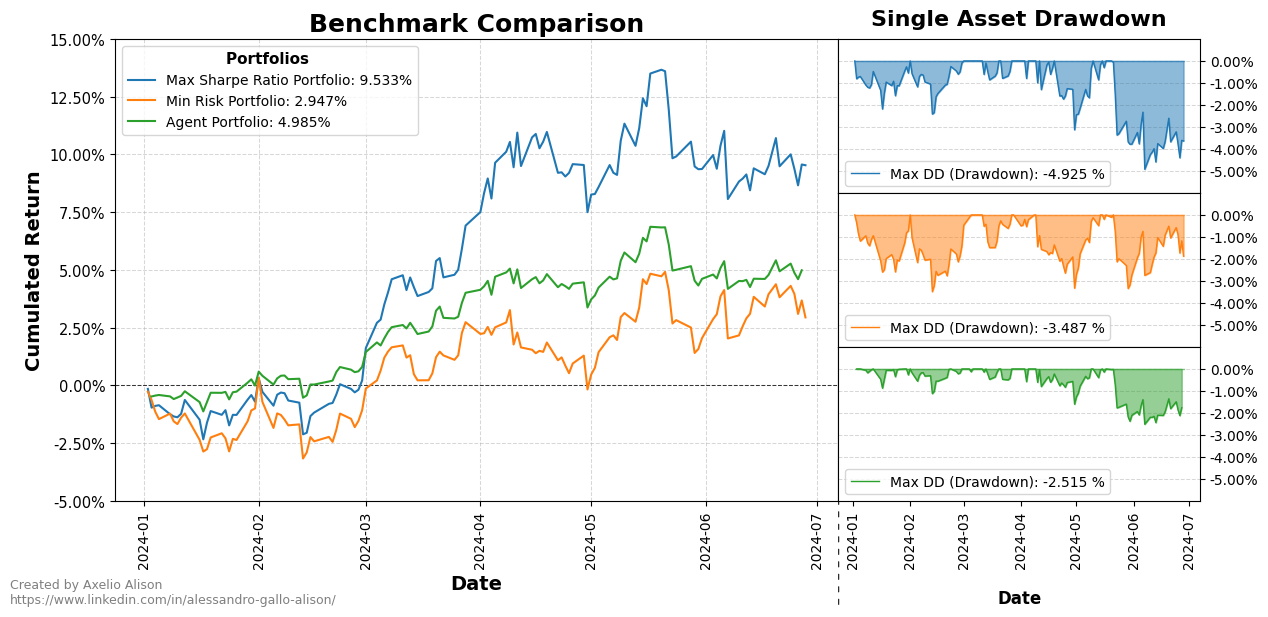

In [86]:
fig = plt.figure(figsize = (14, 6), constrained_layout=False)

# Create a Grid Layout for a more complex visulization
gs = fig.add_gridspec(nrows=3, ncols=3, hspace = 0, wspace = 0)

axp = fig.add_subplot(gs[:, :2])                                # Comparison Ax
side_axs = [fig.add_subplot(gs[i:i+1, 2:]) for i in range(3)]      # Side Axes

# Draw grid
axp.set_axisbelow(True)
axp.grid(linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

# Draw base line
axp.axhline(y = 1, color = 'black', lw = 0.75, ls = '--', alpha = 0.75)

# Plot cumulated returns
axp.plot(max_sr_p.index, max_sr_p.values, label = f"Max Sharpe Ratio Portfolio: {(max_sr_p.values[-1] - 1)*100:.3f}%", lw = 1.5, color = 'C0')
axp.plot(min_std_p.index, min_std_p.values, label = f"Min Risk Portfolio: {(min_std_p.values[-1] - 1)*100:.3f}%", lw = 1.5, color = 'C1')
axp.plot(agent_p.index, agent_p.values, label = f"Agent Portfolio: {(agent_p.values[-1] - 1)*100:.3f}%", lw = 1.5, color = 'C2')

# Modify axes parameters
axp.set_yticks(axp.get_yticks(), [f'{(v - 1)*100:.2f}%' for v in axp.get_yticks()], fontsize = 10.5)
axp.set_xticklabels(axp.get_xticklabels(), rotation = 90)

# Set title and labels
axp.set_title("Benchmark Comparison", fontweight = 'bold', fontsize = 18)
axp.set_ylabel("Cumulated Return", fontweight = 'bold', fontsize = 14)
axp.set_xlabel("Date", fontweight = 'bold', fontsize = 14)
side_axs[0].set_title("Single Asset Drawdown", fontweight = 'bold', fontsize = 16, pad = 10)



# Plot drawdown series in seide axes
side_axs[0].plot(max_sr_p.index, drawdown(max_sr_r).values, lw = 1, color = 'C0', label = f"Max DD (Drawdown): {drawdown(max_sr_r).min()*100:.3f} %")
side_axs[0].plot(max_sr_p.index, base_line, lw = 1, color = 'C0', alpha = 0.5)
side_axs[0].fill_between(max_sr_p.index,  drawdown(max_sr_r).values, 0, color = 'C0', alpha = 0.5)

side_axs[1].plot(min_std_p.index, drawdown(min_std_r).values, lw = 1, color = 'C1', label = f"Max DD (Drawdown): {drawdown(min_std_r).min()*100:.3f} %")
side_axs[1].plot(min_std_p.index, base_line, lw = 1, color = 'C1', alpha = 0.5)
side_axs[1].fill_between(min_std_p.index, drawdown(min_std_r).values, 0, color = 'C1', alpha = 0.5)

side_axs[2].plot(agent_r.index, drawdown(agent_r).values, lw = 1, color = 'C2', label = f"Max DD (Drawdown): {drawdown(agent_r).min()*100:.3f} %")
side_axs[2].plot(min_std_p.index, base_line, lw = 1, color = 'C2', alpha = 0.5)
side_axs[2].fill_between(agent_r.index, drawdown(agent_r).values, 0, color = 'C2', alpha = 0.5)

# Modify side ax parameter
for i in range(3):

    side_axs[i].set_axisbelow(True)
    side_axs[i].grid(axis = 'y', linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

    side_axs[i].yaxis.tick_right()
    side_axs[i].set_yticks(np.linspace(-0.05, 0, 6), [f'{v:.2f}%' for v in np.linspace(-5, 0, 6)])
    side_axs[i].set_ylim((-0.06,0.01))

    side_axs[i].legend(loc = 3)

    if i != 2:
        side_axs[i].set_xticks([], [])
    else:
        side_axs[i].set_xticklabels(side_axs[i].get_xticklabels(), rotation = 90)
        side_axs[i].set_xlabel("Date", fontweight = 'bold', fontsize = 12, labelpad = 15)

# Add legend and modify its properties
axp.legend(loc = 2, title = "Portfolios ", title_fontproperties = {'weight' : 'bold', 'size' : 11})

# Draw a line to separate subplots dates
axp.annotate('', xy=(1.0005, 0.1), xycoords='axes fraction', xytext=(1.0005, -0.23), arrowprops=dict(arrowstyle="-", color='black', lw = 0.75, linestyle = (0, (5, 7))))



fig.text(0.05, -0.04, "Created by Axelio Alison", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)
fig.text(0.05, -0.065, r"https://www.linkedin.com/in/alessandro-gallo-alison/", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)

plt.savefig(image_path + "\\Agent Simulation.png", dpi = 600, bbox_inches = 'tight')
plt.show()

Now, to better compare agent's results in a broader scenario let's calculate all the possible portfolio for the test set (_from 1st January 2024 to 30th June 2024_) results using a __Montecarlo Simulation__.

In [87]:
# Simulating efficientr frontier with test set
portfolios_2 = []
weights_2 = {'GLD w' : [], '^DJI w' : [], 'TLT w' : []}
portfolios_data_2 = {'mean' : [], 'std' : [], 'sharpe_ratio' : []}

for _ in range(5000):

    # Generate Random Weights
    w = np.random.uniform(size = 3)
    w = w/w.sum()
    for i, k in enumerate(weights_2.keys()): weights_2[k].append(w[i])

    # Append the simulation to a list
    p_ret = (test_set1*(w)).sum(axis = 1)
    portfolios_2.append(np.cumprod(p_ret + 1))

    portfolios_data_2['mean'].append(np.mean(p_ret))
    portfolios_data_2['std'].append(np.std(p_ret))
    portfolios_data_2['sharpe_ratio'].append((np.mean(p_ret)/np.std(p_ret))*np.sqrt(252))

portfolios_data_df_2 = pd.DataFrame(weights_2 | portfolios_data_2)

C:\Users\axeli\AppData\Local\Temp\ipykernel_604\257049256.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  side_axs[0].set_xticklabels(side_axs[0].get_xticklabels(), rotation = -90, fontsize = 9)
C:\Users\axeli\AppData\Local\Temp\ipykernel_604\257049256.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  side_axs[1].set_yticklabels(side_axs[1].get_yticklabels(), fontsize = 9)


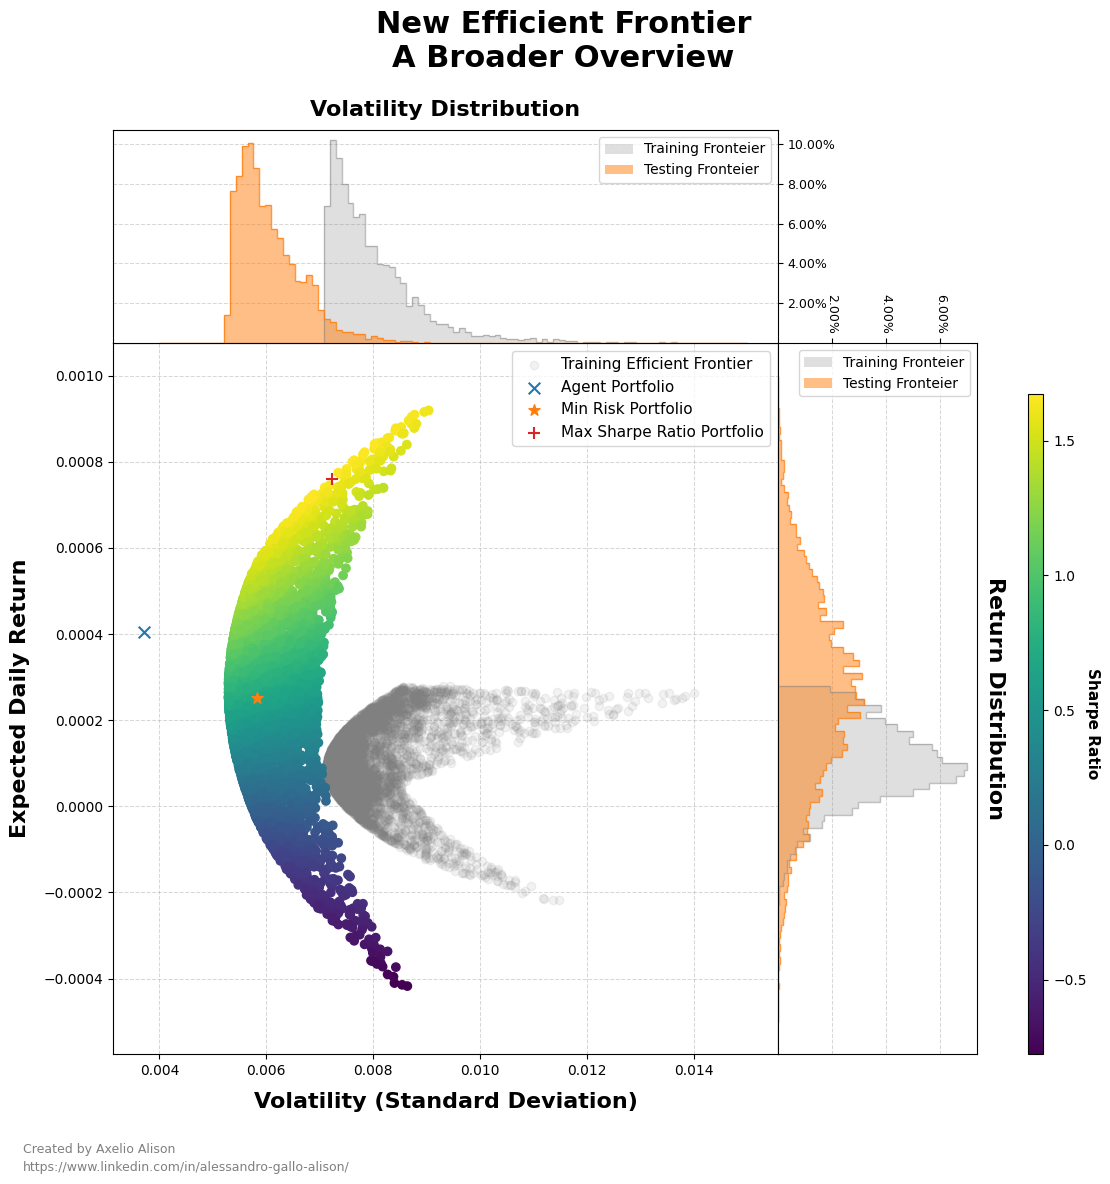

In [88]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Generate figure structure
fig = plt.figure(figsize = (12, 12), constrained_layout=False)

gs = fig.add_gridspec(nrows=3, ncols=3, hspace = 0, wspace = 0, height_ratios = [0, 0.3, 1], width_ratios = [1, 0.3, 0.1])
cbar_gs = fig.add_gridspec(nrows=3, ncols=3, hspace = 0, wspace = 5, height_ratios = [0.1, 0.3, 1], width_ratios = [1, 0.3, 0.1])

axp = fig.add_subplot(gs[2, 0])

# Distribution Axes
side_axs = []   
side_axs.append(fig.add_subplot(gs[2, 1], sharey = axp))
side_axs.append(fig.add_subplot(gs[1, 0], sharex = axp))
cbar_ax = fig.add_subplot(cbar_gs[2, 2])




# Draw grid
axp.set_axisbelow(True)
axp.grid(linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

# Plot Efficient frontier chart
axp.scatter(portfolios_data_df['std'], portfolios_data_df['mean'], color = 'gray', alpha = 0.1, label = "Training Efficient Frontier")
sc = axp.scatter(portfolios_data_df_2['std'], portfolios_data_df_2['mean'], c = portfolios_data_df_2['sharpe_ratio'])

# Plotting benchmarks and agent portfolio in the efficient frontier chart
axp.scatter(np.std(agent_r[1:]), np.mean(agent_r[1:]), 70, color = 'C0', marker = 'x', label = 'Agent Portfolio')
axp.scatter(np.std(min_std_r), np.mean(min_std_r), 70, color = 'C1', marker = '*', label = "Min Risk Portfolio")
axp.scatter(np.std(max_sr_r), np.mean(max_sr_r), 70, color = 'C3', marker = '+', label = "Max Sharpe Ratio Portfolio")

# Add colorbar based on shrape ratio
fig.colorbar(sc, cax=cbar_ax, orientation='vertical')

# Midify ticks
#axp.set_yticks(ax.get_yticks()[1:-1], [f'{v*100:.2f}%' for v in ax.get_yticks()[1:-1]])

# Add title and axis label
axp.set_title("New Efficent Fronteier", fontsize = 18, fontweight = 'bold', pad = 10)
axp.set_xlabel("Volatility (Standard Deviation)", labelpad = 10, fontsize = 16, fontweight = 'bold')
axp.set_ylabel("Expected Daily Return", labelpad = 10, fontsize = 16, fontweight = 'bold')
cbar_ax.set_ylabel("Sharpe Ratio", rotation = -90, labelpad = 10, fontsize = 11, fontweight = 'bold')

# Adde Legend
axp.legend(loc = 1, fontsize = 11)



# Plot Average Return Distribution
side_axs[0].hist(portfolios_data_df['mean'], range = (-0.0005, 0.001), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  orientation = 'horizontal', histtype = 'stepfilled', alpha = 0.25, color = 'gray', label = "Training Fronteier")
side_axs[0].hist(portfolios_data_df['mean'], range = (-0.0005, 0.001), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  orientation = 'horizontal', histtype = 'step', alpha = 0.50, color = 'gray')
side_axs[0].hist(portfolios_data_df_2['mean'], range = (-0.0005, 0.001), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  orientation = 'horizontal', histtype = 'stepfilled', alpha = 0.50, color = 'C1', label = "Testing Fronteier")
side_axs[0].hist(portfolios_data_df_2['mean'], range = (-0.0005, 0.001), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  orientation = 'horizontal', histtype = 'step', alpha = 0.80, color = 'C1')

# Plot Volatility Distribution
side_axs[1].hist(portfolios_data_df['std'], range = (0.004, 0.015), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  histtype = 'stepfilled', alpha = 0.25, color = 'gray', label = "Training Fronteier")
side_axs[1].hist(portfolios_data_df['std'], range = (0.004, 0.015), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  histtype = 'step', alpha = 0.50, color = 'gray')
side_axs[1].hist(portfolios_data_df_2['std'], range = (0.004, 0.015), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  histtype = 'stepfilled', alpha = 0.50, color = 'C1', label = "Testing Fronteier")
side_axs[1].hist(portfolios_data_df_2['std'], range = (0.004, 0.015), bins = 100, rwidth = 0.9, weights = [1/5000]*5000,
                  histtype = 'step', alpha = 0.80, color = 'C1')

# Modify ticks position
side_axs[0].tick_params(left=False, labelleft = False, bottom = False, labelbottom = False, top = True, labeltop = True)
side_axs[0].set_xticklabels(side_axs[0].get_xticklabels(), rotation = -90, fontsize = 9)
side_axs[0].set_xticks(side_axs[0].get_xticks()[1:-1], [f'{v*100:.2f}%' for v in side_axs[0].get_xticks()[1:-1]])

side_axs[1].tick_params(bottom=False, labelbottom = False)
side_axs[1].yaxis.tick_right()
side_axs[1].set_yticklabels(side_axs[1].get_yticklabels(), fontsize = 9)
side_axs[1].set_yticks(side_axs[1].get_yticks()[1:-1], [f'{v*100:.2f}%' for v in side_axs[1].get_yticks()[1:-1]])

# Set grid
side_axs[0].set_axisbelow(True)
side_axs[0].grid(axis = 'x', linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)
side_axs[1].set_axisbelow(True)
side_axs[1].grid(axis = 'y', linestyle = 'dashed', linewidth = 0.75, alpha = 0.5)

# Add title and axis label
side_axs[0].yaxis.set_label_position("right")
side_axs[0].set_ylabel("Return Distribution", rotation = -90, fontsize = 16, fontweight = 'bold', labelpad = 20)

side_axs[1].xaxis.set_label_position("top")
side_axs[1].set_xlabel("Volatility Distribution", fontsize = 16, fontweight = 'bold', labelpad = 10)

# Add legend
side_axs[0].legend()
side_axs[1].legend()

fig.suptitle("New Efficient Frontier\nA Broader Overview", fontsize = 22, fontweight = 'bold')

fig.text(0.05, 0.025, "Created by Axelio Alison", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)
fig.text(0.05, 0.01, r"https://www.linkedin.com/in/alessandro-gallo-alison/", fontsize = 9, horizontalalignment = 'left', verticalalignment = 'bottom', alpha = 0.5)

# Save and plot figure
plt.savefig(image_path + "\\New Efficient Frontier.png", dpi = 600, bbox_inches = 'tight')
plt.show()

## Conclusion
As we can see from the metrics, taking in consideration the _Sharpe Ratio_ and the _Max Drawdown_ parameter we can observe that the Agent Portfolio performed __significantly better__ than the two benchmarks considered. The agent portfolio has a _Max Drawdown_ of -2.515%, almost of the portfolio that maximizes the _Sharpe Ratio_, and obtains a higher _Sharpe Ratio_ value compared to the other two benchmarks.

In conclusion, we could say that the agent performs better than the benchmarks and seems to be a good model. However, to verify that the structure of the chosen model is statistically relevant, we will have to do further tests by initializing the agent with always different initial weights, but this will not be the purpose of this study, given the limited computational power at my disposal.